In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Activation
from tensorflow.keras.models import Model
import cv2

In [2]:
train_img = []
train_mask = []

val_img = []
val_mask =[]

test_img =[]
test_mask = []

for i in range(1,2500):
    train_img.append('/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    train_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )

for i in range(2500,2750):
    val_img.append( '/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    val_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )

for i in range(2750,3001):
    test_img.append( '/content/drive/MyDrive/brain tumer/images/' + f'{str(i)}.png')
    test_mask.append('/content/drive/MyDrive/brain tumer/masks/' + f'{str(i)}.png' )



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset(img_paths, mask_paths, img_size = (128, 128)):
    def processing(img_path, mask_path, img_size=(128,128)):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels= 3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels= 1)
        mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(mask, tf.int32)
        # Remap mask values: assuming 255 is foreground, remap to 1
        mask = tf.where(mask == 255, 1, mask)

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(processing, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset




# Number of classes
num_classes = 2

# input layer
input_tensor = tf.keras.Input(shape=(128, 128, 3))

# Useing MobileNetV2 as the encoder 
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Connecting the input to the model
x = base_model(input_tensor) 

# simple decoder to upsample the features to the original size
x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x) # Output: 8x8
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) # Output: 16x16
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x) # Output: 32x32
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x) # Output: 64x64
x = Activation('relu')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x) # Output: 128x128
x = Activation('relu')(x)

# Final convolutional layer

output_tensor = Conv2D(num_classes, (1, 1), activation='softmax')(x)

# full segmentation model
model = Model(inputs=input_tensor, outputs=output_tensor)




# Recreateing datasets to ensure correct mask processing.

trainset = dataset(train_img, train_mask, img_size=(128,128))
trainset = trainset.batch(32).prefetch(tf.data.AUTOTUNE)

valset = dataset(val_img, val_mask, img_size=(128,128))
valset = valset.batch(32).prefetch(tf.data.AUTOTUNE)

testset = dataset(test_img, test_mask, img_size = (128, 128))
testset = testset.batch(32).prefetch(tf.data.AUTOTUNE)





# Trainig
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'bestmodel.h5',
        save_best_only= True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience = 10,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor = 0.1,
        patience = 5
    )
]

model.compile(optimizer= tf.keras.optimizers.Adam(),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(trainset, epochs= 30, callbacks= callbacks)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9252 - loss: 0.2391

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


79/79 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.9258 - loss: 0.2376 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0525

79/79 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9835 - loss: 0.0525 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0447

79/79 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.9835 - loss: 0.0446 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0406

79/79 ━━━━━━━━━━━━━━━━━━━━ 364s 5s/step - accuracy: 0.9835 - loss: 0.0406 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0346

79/79 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.9835 - loss: 0.0346 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9835 - loss: 0.0315

79/79 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.9835 - loss: 0.0315 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9841 - loss: 0.0296

79/79 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.9841 - loss: 0.0295 - learning_rate: 0.0010
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9889 - loss: 0.0265

79/79 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.9888 - loss: 0.0266 - learning_rate: 0.0010
Epoch 9/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9893 - loss: 0.0259

79/79 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.9893 - loss: 0.0259 - learning_rate: 0.0010
Epoch 10/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9902 - loss: 0.0235

79/79 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.9902 - loss: 0.0235 - learning_rate: 0.0010
Epoch 11/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9908 - loss: 0.0226

79/79 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.9908 - loss: 0.0226 - learning_rate: 0.0010
Epoch 12/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9909 - loss: 0.0224

79/79 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.9909 - loss: 0.0224 - learning_rate: 0.0010
Epoch 13/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9909 - loss: 0.0218

79/79 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.9909 - loss: 0.0218 - learning_rate: 0.0010
Epoch 14/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9908 - loss: 0.0224

79/79 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.9908 - loss: 0.0224 - learning_rate: 0.0010
Epoch 15/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9914 - loss: 0.0207

79/79 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9914 - loss: 0.0207 - learning_rate: 0.0010
Epoch 16/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9915 - loss: 0.0205

79/79 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9915 - loss: 0.0205 - learning_rate: 0.0010
Epoch 17/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9912 - loss: 0.0208

79/79 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.9912 - loss: 0.0208 - learning_rate: 0.0010
Epoch 18/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9923 - loss: 0.0184

79/79 ━━━━━━━━━━━━━━━━━━━━ 386s 5s/step - accuracy: 0.9923 - loss: 0.0184 - learning_rate: 0.0010
Epoch 19/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9917 - loss: 0.0200

79/79 ━━━━━━━━━━━━━━━━━━━━ 372s 5s/step - accuracy: 0.9917 - loss: 0.0199 - learning_rate: 0.0010
Epoch 20/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9921 - loss: 0.0185

79/79 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9921 - loss: 0.0185 - learning_rate: 0.0010
Epoch 21/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9929 - loss: 0.0168

79/79 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.9929 - loss: 0.0168 - learning_rate: 0.0010
Epoch 22/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9924 - loss: 0.0179

79/79 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.9924 - loss: 0.0179 - learning_rate: 0.0010
Epoch 23/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9930 - loss: 0.0165

79/79 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.9930 - loss: 0.0165 - learning_rate: 0.0010
Epoch 24/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9937 - loss: 0.0152

79/79 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.9937 - loss: 0.0152 - learning_rate: 0.0010
Epoch 25/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9934 - loss: 0.0155

79/79 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.9934 - loss: 0.0155 - learning_rate: 0.0010
Epoch 26/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9934 - loss: 0.0156

79/79 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.9934 - loss: 0.0156 - learning_rate: 0.0010
Epoch 27/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9936 - loss: 0.0153

79/79 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.9936 - loss: 0.0153 - learning_rate: 0.0010
Epoch 28/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9929 - loss: 0.0168

79/79 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.9929 - loss: 0.0168 - learning_rate: 0.0010
Epoch 29/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9933 - loss: 0.0157

79/79 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.9933 - loss: 0.0157 - learning_rate: 0.0010
Epoch 30/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9940 - loss: 0.0141

79/79 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9940 - loss: 0.0141 - learning_rate: 0.0010


In [4]:
def predict (model, img_path, img_size=(128,128)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3) 
    org_size = tf.shape(img)[:2]

    img = tf.image.resize(img , img_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis = 0)

    pred = model.predict(img)
    pred = tf.argmax(pred, axis = -1 )

    pred = tf.image.resize(
        tf.expand_dims(pred, axis = -1),
        org_size,
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return tf.squeeze(pred).numpy()

In [5]:
def visualize(img, mask, pred):
    fig, axes = plt.subplots(1,3, figsize= (15,5))

    axes[0].imshow(img)
    axes[0].set_title('original')

    axes[1].imshow(mask)
    axes[1].set_title('ground truth')

    axes[2].imshow(pred)
    axes[2].set_title('prediction')


    plt.show()

83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


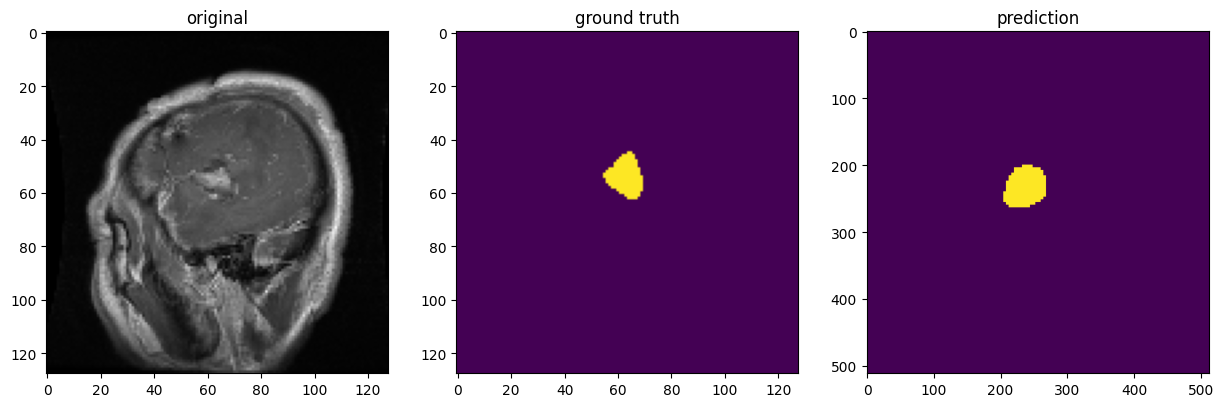

In [19]:
x = np.random.randint(100)

print(x)
sample_img_path = test_img[x]
sample_mask_path = test_mask[x]

# original image
original_img = tf.io.read_file(sample_img_path)
original_img = tf.image.decode_png(original_img, channels=3)
original_img = tf.image.resize(original_img, (128,128))
original_img = tf.cast(original_img, tf.float32) / 255.0

# original mask 
ground_truth_mask = tf.io.read_file(sample_mask_path)
ground_truth_mask = tf.image.decode_png(ground_truth_mask, channels=1)
ground_truth_mask = tf.image.resize(ground_truth_mask, (128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
ground_truth_mask = tf.where(ground_truth_mask == 255, 1, ground_truth_mask)
ground_truth_mask = tf.squeeze(ground_truth_mask).numpy()


# Prediction
predicted_mask = predict(model, sample_img_path)

# Visualizing the results
visualize(original_img.numpy(), ground_truth_mask, predicted_mask)